In [ ]:
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from keras.optimizers import Adam

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
import tensorflow as tf
import io
import csv

tf.keras.backend.set_floatx('float64')

In [ ]:
!git clone https://github.com/borate267/lexicon-dataset.git

Cloning into 'lexicon-dataset'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 30 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [ ]:
train_dir = "lexicon-dataset/ta.translit.sampled.train.tsv"
test_dir = "lexicon-dataset/ta.translit.sampled.test.tsv"

# The following function reads the raw text document and returns a list of lists comprising the romanized and native versions of the words

def read_corpus(corpus_file):
  tamil_words = []
  latin_words = []
  with io.open(corpus_file, encoding ='utf-8') as f:
    for line in f:
      if '\t' not in line:
        continue
      tokens = line.rstrip().split("\t")
      latin_words.append(tokens[1])
      tamil_words.append(tokens[0])
  return latin_words, tamil_words

train_source, train_target = read_corpus(train_dir)
test_source, test_target = read_corpus(test_dir)

print("Number of training samples: ", len(train_source))
print("Number of testing samples: ", len(test_source))


Number of training samples:  68218
Number of testing samples:  6864


In [ ]:
arr = np.arange(len(train_source))
np.random.shuffle(arr)
arr1 = np.arange(len(test_source))
np.random.shuffle(arr1)

input_characters = set()
target_characters = set()
input_texts_ns = []
target_texts_ns = []
test_input_texts_ns = []
test_target_texts_ns = []

for (input_text, target_text) in zip(train_source, train_target):
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "B" + target_text + "E"
    input_texts_ns.append(input_text)
    target_texts_ns.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

for (input_text, target_text) in zip(test_source, test_target):
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "B" + target_text + "E"
    test_input_texts_ns.append(input_text)
    test_target_texts_ns.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_texts = []
target_texts = []

for i in range(len(train_source)):
    input_texts.append(input_texts_ns[arr[i]])
    target_texts.append(target_texts_ns[arr[i]])

test_input_texts = []
test_target_texts = []

for i in range(len(test_source)):
    test_input_texts.append(test_input_texts_ns[arr1[i]])
    test_target_texts.append(test_target_texts_ns[arr1[i]])

input_characters.add(" ")
target_characters.add(" ")

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

# Adding the padding character
#input_characters.append("P")
#target_characters.append("P")

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
test_max_encoder_seq_length = max([len(txt) for txt in test_input_texts])
test_max_decoder_seq_length = max([len(txt) for txt in test_target_texts])


print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)
print("Max sequence length for val inputs:", test_max_encoder_seq_length)
print("Max sequence length for val outputs:", test_max_decoder_seq_length)

print(input_characters)
print(target_characters)

Number of samples: 68218
Number of unique input tokens: 27
Number of unique output tokens: 49
Max sequence length for inputs: 30
Max sequence length for outputs: 28
Max sequence length for val inputs: 23
Max sequence length for val outputs: 24
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[' ', 'B', 'E', 'ஃ', 'அ', 'ஆ', 'இ', 'ஈ', 'உ', 'ஊ', 'எ', 'ஏ', 'ஐ', 'ஒ', 'ஓ', 'க', 'ங', 'ச', 'ஜ', 'ஞ', 'ட', 'ண', 'த', 'ந', 'ன', 'ப', 'ம', 'ய', 'ர', 'ற', 'ல', 'ள', 'ழ', 'வ', 'ஷ', 'ஸ', 'ஹ', 'ா', 'ி', 'ீ', 'ு', 'ூ', 'ெ', 'ே', 'ை', 'ொ', 'ோ', 'ௌ', '்']


In [ ]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
reverse_source_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())
print(input_token_index)
print(target_token_index)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{' ': 0, 'B': 1, 'E': 2, 'ஃ': 3, 'அ': 4, 'ஆ': 5, 'இ': 6, 'ஈ': 7, 'உ': 8, 'ஊ': 9, 'எ': 10, 'ஏ': 11, 'ஐ': 12, 'ஒ': 13, 'ஓ': 14, 'க': 15, 'ங': 16, 'ச': 17, 'ஜ': 18, 'ஞ': 19, 'ட': 20, 'ண': 21, 'த': 22, 'ந': 23, 'ன': 24, 'ப': 25, 'ம': 26, 'ய': 27, 'ர': 28, 'ற': 29, 'ல': 30, 'ள': 31, 'ழ': 32, 'வ': 33, 'ஷ': 34, 'ஸ': 35, 'ஹ': 36, 'ா': 37, 'ி': 38, 'ீ': 39, 'ு': 40, 'ூ': 41, 'ெ': 42, 'ே': 43, 'ை': 44, 'ொ': 45, 'ோ': 46, 'ௌ': 47, '்': 48}


In [ ]:
trunc_input_texts = input_texts[:68096]
trunc_target_texts = target_texts[:68096]

encoder_input_data = np.zeros(
    (len(trunc_input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float64"
)
decoder_target_data = np.zeros(
    (len(trunc_input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float64"
)

for i, (input_text, target_text) in enumerate(zip(trunc_input_texts, trunc_target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_target_data[i, t, target_token_index[char]] = 1.0
    decoder_target_data[i, t + 1 :, target_token_index[" "]] = 1.0
    
test_encoder_input_data = np.zeros(
    (len(test_input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float64"
)
test_decoder_target_data = np.zeros(
    (len(test_target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float64"
)

for i, (input_text, target_text) in enumerate(zip(test_input_texts, test_target_texts)):
    for t, char in enumerate(input_text):
        test_encoder_input_data[i, t, input_token_index[char]] = 1.0
    #encoder_input_data[i, t + 1 :] = input_token_index["P"]
    test_encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

    for t, char in enumerate(target_text):
      # decoder_target_data is ahead of decoder_input_data by one timestep
        test_decoder_target_data[i, t, target_token_index[char]] = 1.0
    test_decoder_target_data[i, t + 1: ,target_token_index[" "]] = 1.0
  


# ATTENTION MECHANISM 

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    
  def call(self, query, values):
    
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)
    
    
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights


In [ ]:
#import tensorflow 
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
   
    query_with_time_axis = tf.expand_dims(query, 1)
    
    values_transposed = tf.transpose(values, perm=[0, 2, 1])
    
    #LUONGH Dot-product
    score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed) , perm=[0, 2, 1])

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class MyRNN_atten(object):
  def __init__(self,cell_type = 'RNN', hidden_size=32, 
               learning_rate= 1e-3,dropout=0.3,epochs = 10, batch_size = 32,
               attention = 'bahdanau'):
    
    self.cell_type = cell_type
    self.hidden_size = hidden_size
    self.learning_rate = learning_rate
    self.dropout = dropout
    self.epochs = epochs
    self.batch_size = batch_size
    self.attention = attention

  def build_fit(self,encoder_input_data,decoder_target_data):

    encoder_inputs = Input(shape=(max_encoder_seq_length, num_encoder_tokens), name='encoder_inputs')
    if self.cell_type == 'LSTM':
      encoder_lstm = LSTM(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_lstm')
      encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
      encoder_states = [encoder_state_h, encoder_state_c]
    elif self.cell_type == 'GRU':
      encoder_gru = GRU(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_gru')
      encoder_outputs, encoder_state_h = encoder_gru(encoder_inputs)
      encoder_states = [encoder_state_h]
    elif self.cell_type == 'RNN':
      encoder_rnn = SimpleRNN(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_rnn')
      encoder_outputs, encoder_state_h = encoder_rnn(encoder_inputs)
      encoder_states = [encoder_state_h]

    # Set up the attention layer
    if self.attention == 'bahdanau':
      attention= BahdanauAttention(self.hidden_size)
    elif self.attention == 'luong':
      attention= LuongAttention(self.hidden_size)

    # Set up the decoder layers
    decoder_inputs = Input(shape=(1, (num_decoder_tokens+self.hidden_size)),name='decoder_inputs')
    if self.cell_type == 'LSTM':
      decoder_lstm = LSTM(self.hidden_size, dropout = self.dropout, return_state=True, name='decoder_lstm')
    elif self.cell_type == 'GRU':
      decoder_gru = GRU(self.hidden_size, dropout = self.dropout, return_state=True, name='decoder_gru')
    elif self.cell_type == 'RNN':
      decoder_rnn = SimpleRNN(self.hidden_size, dropout = self.dropout, return_state=True, name='decoder_rnn')  
    
    decoder_dense = Dense(num_decoder_tokens, activation='softmax',  name='decoder_dense')

    all_outputs = []

    inputs = np.zeros((self.batch_size, 1, num_decoder_tokens))
    inputs[:, 0, 0] = 1 

    decoder_outputs = encoder_state_h
    states = encoder_states

    for _ in range(max_decoder_seq_length):

      context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
      
      context_vector = tf.expand_dims(context_vector, 1)
      
      inputs = tf.concat([context_vector, inputs], axis=-1)
      if self.cell_type == 'LSTM':
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
      if self.cell_type == 'GRU':
        decoder_outputs, state_h = decoder_gru(inputs, initial_state=states)
      if self.cell_type == 'RNN':
        decoder_outputs, state_h = decoder_rnn(inputs, initial_state=states)
      
      outputs = decoder_dense(decoder_outputs)
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)
      inputs = outputs
      if self.cell_type == 'LSTM':
        states = [state_h, state_c]
      if self.cell_type == 'GRU' or self.cell_type == 'RNN':
        states = [state_h]


    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    #getindicelayer = Lambda(lambda x: x[:, -1, :]) 
    #decoder_outputs = getindicelayer(all_outputs)

    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    
    optimizer = Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    #model.summary()

    model.fit(encoder_input_data, decoder_target_data,
              batch_size=self.batch_size, 
              epochs=self.epochs,
              #callbacks = [WandbCallback()]
              )
    
    global_total = 0
    global_correct = 0
    test_count = 6784

    pred = model.predict(test_encoder_input_data[:test_count], batch_size = self.batch_size)

    data_list = [["SNO", "Input Data", "Target Data", "Predicted Data"]]

    for index in range(0,test_count):
      pred_vector = pred[index]
      true_vector = test_decoder_target_data[index]
      pred_indices = tf.argmax(pred_vector, axis=1)
      true_indices = tf.argmax(true_vector, axis=1)

      if (pred_indices.numpy() == true_indices.numpy()).all():
        global_correct = global_correct + 1
      
      global_total = global_total + 1

      arr = pred_indices.numpy()
      decoded_sequence = ''
      for i in range(1,len(arr)):
        if arr[i] != 2:
          decoded_sequence = decoded_sequence + reverse_target_char_index[arr[i]]

      true_word = test_target_texts[index] 
      true_word = true_word[1:len(true_word)-1]
      #print(true_word)
      #print(decoded_sequence)
      dlist = [index+1, test_input_texts[index], true_word, decoded_sequence]
      data_list.append(dlist)

    with open('predictions_attention.tsv', 'w', newline='') as file:
      writer = csv.writer(file, delimiter='\t')
      writer.writerows(data_list)

    val_accuracy = global_correct/global_total
    print(val_accuracy)

In [ ]:
# BEST HYPERPARAMETERS

best_attention = 'bahdanau'
best_batch_size = 128
best_cell_type = 'RNN'
best_dropout = 0
best_epochs = 20
best_hidden_size = 128
best_learning_rate = 0.001


In [ ]:
model_rnn = MyRNN_atten(cell_type = best_cell_type, hidden_size=best_hidden_size, learning_rate= best_learning_rate,
                        dropout=best_dropout,epochs = best_epochs, batch_size = best_batch_size, attention = best_attention)

In [ ]:
model_rnn.build_fit(encoder_input_data,decoder_target_data)

Epoch 1/20
532/532 [==============================] - 52s 60ms/step - loss: 1.3523 - accuracy: 0.6689
Epoch 2/20
532/532 [==============================] - 32s 61ms/step - loss: 0.8321 - accuracy: 0.7436
Epoch 3/20
532/532 [==============================] - 32s 60ms/step - loss: 0.5252 - accuracy: 0.8403
Epoch 4/20
532/532 [==============================] - 32s 60ms/step - loss: 0.3607 - accuracy: 0.9077
Epoch 5/20
532/532 [==============================] - 32s 60ms/step - loss: 0.3069 - accuracy: 0.9235
Epoch 6/20
532/532 [==============================] - 32s 60ms/step - loss: 0.2830 - accuracy: 0.9291
Epoch 7/20
532/532 [==============================] - 32s 61ms/step - loss: 0.2657 - accuracy: 0.9334
Epoch 8/20
532/532 [==============================] - 32s 61ms/step - loss: 0.2646 - accuracy: 0.9331
Epoch 9/20
532/532 [==============================] - 32s 61ms/step - loss: 0.2438 - accuracy: 0.9388
Epoch 10/20
532/532 [==============================] - 32s 61ms/step - loss: 0.252

In [ ]:
def evaluate(seq_in):
  attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
  print ('attention_plot shape: (n_timesteps_in, n_timesteps_in) {}'.format(attention_plot.shape))

  #sequence = [7, 9, 8, 5]
  #sequence = one_hot_encode(seq_in,n_features)
  encoder_inputs = array(seq_in).reshape(1,n_timesteps_in,n_features)
  
  encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
  print ('Encoder input shape: (batch size, sequence length, n_features) {}'.format(encoder_inputs.shape))


  encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

  print ('Encoder output shape: (batch size, sequence length, latentSpaceDimension) {}'.format(encoder_outputs.shape))
  print ('Encoder Hidden state shape: (batch size, latentSpaceDimension) {}'.format(state_h.shape))
  print ('Encoder Cell state shape: (batch size, latentSpaceDimension) {}'.format(state_c.shape))
  # initial context vector is the states of the encoder
  states = [state_h, state_c]
  
  # Set up the attention layer
  #attention= BahdanauAttention(latentSpaceDimension)


  # Set up the decoder layers
  #decoder_inputs = Input(shape=(1, (n_features+latentSpaceDimension)))
  #decoder_lstm = LSTM(latentSpaceDimension,  return_state=True, name='decoder_lstm')
  #decoder_dense = Dense(n_features, activation='softmax',  name='decoder_dense')

  all_outputs = []

  #INIT DECODER
  # Prepare decoder input data that just contains the start character 0
  # Note that we made it a constant one-hot-encoded in the model
  # that is, [1 0 0 0 0 0 0 0 0 0] is the first input for each loop
  decoder_input_data = np.zeros((1, 1, n_features))
  decoder_input_data[:, 0, 0] = 1 
  # that is, [1 0 0 0 0 0 0 0 0 0] is the first input for each loop
  inputs = decoder_input_data
  #initial hiiden state
  decoder_outputs = state_h

  print('initial decoder inputs: ', inputs.shape)

  # decoder will only process one timestep at a time.
  for t in range(n_timesteps_in):

      # pay attention
      context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)



      print("Attention context_vector: (batch size, units) {}".format(context_vector.shape))
      print("Attention weights : (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

      # storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()

      
      decoder_outputs=tf.expand_dims(decoder_outputs, 1)
      print('decoder_outputs: (batch_size, 1, latentSpaceDimension) ', decoder_outputs.shape )

      context_vector = tf.expand_dims(context_vector, 1)
      print('Reshaped context_vector: ', context_vector.shape )
      inputs = tf.concat([context_vector, inputs], axis=-1)
      #inputs = tf.concat([context_vector, inputs], axis=-1)
      print('After concat inputs: (batch_size, 1, n_features + hidden_size): ',inputs.shape )

      # passing the concatenated vector to the LSTM
      # Run the decoder on one timestep
      decoder_outputs, state_h, state_c = decoder_lstm(inputs,
                                              initial_state=states)
      #decoder_outputs = tf.reshape(decoder_outputs, (-1, decoder_outputs.shape[2]))
    
      outputs = decoder_dense(decoder_outputs)
      # Store the current prediction (we will concatenate all predictions later)
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)
      # Reinject the outputs as inputs for the next loop iteration
      # as well as update the states
      inputs = outputs
      states = [state_h, state_c]



  # Concatenate all predictions such as [batch_size, timesteps, features]
  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  seq_out=one_hot_decode(decoder_outputs[0])
  
  return seq_in, seq_out, attention_plot



time: 63.8 ms


In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sequence, predicted_sequence):
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()



time: 10.3 ms


In [ ]:
def translate(seq_in):
  seq_in, seq_out, attention_plot = evaluate(seq_in)

  print('Input: %s' % (seq_in))
  print('Predicted translation: {}'.format(seq_out))

  attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
  plot_attention(attention_plot, seq_in, seq_out)

time: 3.59 ms


attention_plot shape: (n_timesteps_in, n_timesteps_in) (4, 4)
Encoder input shape: (batch size, sequence length, n_features) (1, 4, 10)
Encoder output shape: (batch size, sequence length, latentSpaceDimension) (1, 4, 16)
Encoder Hidden state shape: (batch size, latentSpaceDimension) (1, 16)
Encoder Cell state shape: (batch size, latentSpaceDimension) (1, 16)
initial decoder inputs:  (1, 1, 10)
Attention context_vector: (batch size, units) (1, 16)
Attention weights : (batch_size, sequence_length, 1) (1, 4, 1)
decoder_outputs: (batch_size, 1, latentSpaceDimension)  (1, 1, 16)
Reshaped context_vector:  (1, 1, 16)
After concat inputs: (batch_size, 1, n_features + hidden_size):  (1, 1, 26)
Attention context_vector: (batch size, units) (1, 16)
Attention weights : (batch_size, sequence_length, 1) (1, 4, 1)
decoder_outputs: (batch_size, 1, latentSpaceDimension)  (1, 1, 16)
Reshaped context_vector:  (1, 1, 16)
After concat inputs: (batch_size, 1, n_features + hidden_size):  (1, 1, 26)
Attention

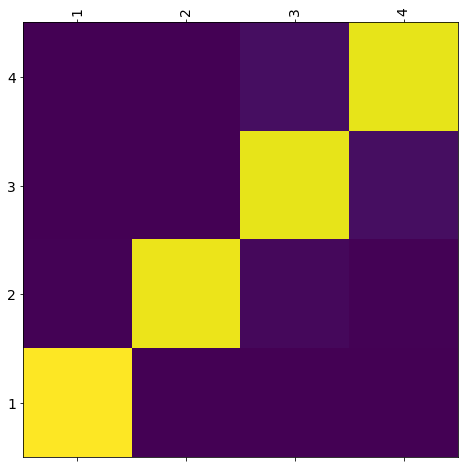

time: 176 ms


In [ ]:
#translate([1, 2, 3 ,4,5,6,7,8,9,1,2,3,4,5,7,6])
translate([1, 2, 3 ,4])